# Replication of Figs & Tables

## Load LevFac Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

df = pd.read_csv('LevFac.csv', index_col=0)
df.index = pd.PeriodIndex(df.index, freq='Q')
df.tail()

,LevFacOri,ZLevFacOri,ZLogLevOri,LevFacCurrent,ZLevFacCurrent,ZLogLevCurrent
DATES,,,,,,
2008Q4,-0.614654,-4.782984,1.048600,-0.370011,-4.810401,1.104707
2009Q1,-0.161919,-1.426519,0.684362,-0.047752,-0.674710,0.894071
2009Q2,-0.184683,-1.595289,0.399756,-0.154505,-2.044721,0.567141
2009Q3,-0.042179,-0.538797,0.327376,-0.010884,-0.201571,0.535602
2009Q4,0.170394,1.037170,0.662057,-0.092402,-1.247721,0.398025


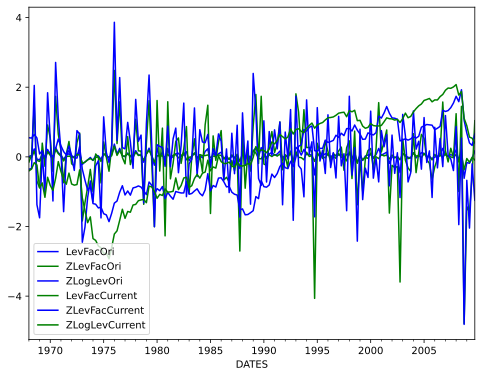

In [2]:
compare_lev_fac = df.loc["1968Q1":]
compare_lev_fac.plot(color=['blue', 'green'], figsize=(8, 6))
plt.legend(loc='lower left')
plt.grid(False)
#plt.savefig('compare_leverage_plot.png')

In [4]:
LevFac = df[['LevFacOri']].loc['1968Q1':'2009Q4']
#LevFac = df[['LevFacNew']].loc['1968Q1':]
#LevFac = df[['LevFacNew']].loc['2010Q1':]
LevFac.columns = ['LevFac']
LevFac

,LevFac
DATES,
1968Q1,0.010283
1968Q2,0.037533
1968Q3,0.226723
1968Q4,-0.063279
1969Q1,-0.088941
...,...
2008Q4,-0.614654
2009Q1,-0.161919
2009Q2,-0.184683


## One-Time Beta

### 25 Portfolios Formed on Size & BM 

In [5]:
test_25 = pd.read_csv('datasets/25_Portfolios_5x5.csv', skiprows=15, index_col=0)
test_25.index = pd.to_datetime(test_25.index, format='%Y%m')
test_25.columns = [i.replace('SMALL HiBM', 'S1 B5').replace('SMALL LoBM', 'S1 B1').replace('BIG LoBM', 'S5 B1').replace('BIG HiBM', 'S5 B5').replace('BM', 'B').replace('ME', 'S').replace(' ', '') for i in test_25.columns]
test_25 = test_25 / 100.0
test_25.head(3)

,S1B1,S1B2,S1B3,S1B4,S1B5,S2B1,S2B2,S2B3,S2B4,S2B5,...,S4B1,S4B2,S4B3,S4B4,S4B5,S5B1,S5B2,S5B3,S5B4,S5B5
1926-07-01,0.058276,-0.017006,0.005118,-0.021477,0.019583,0.012118,0.024107,0.006056,-0.026082,-0.004527,...,0.015376,0.015460,0.013389,0.002765,0.024678,0.033248,0.060909,0.020285,0.031263,0.005623
1926-08-01,-0.020206,-0.080282,0.013968,0.021483,0.085104,0.023620,-0.007525,0.038984,0.002299,0.062937,...,0.013858,0.038587,0.019738,0.021336,0.053422,0.010169,0.041975,0.019769,0.054924,0.077576
1926-09-01,-0.048291,-0.026806,-0.043417,-0.032683,0.008586,-0.026849,-0.005252,0.010789,-0.032877,-0.009419,...,0.016897,-0.005246,-0.017724,0.014806,0.008730,-0.012951,0.036610,0.001384,-0.007497,-0.024284


### 10 Portfolios Formed on Momentum
Download 10 Portfolios Formed on Momentum from [link](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) 

In [6]:
test_10 = pd.read_csv('datasets/10_Portfolios_Prior_12_2.csv', skiprows=10, index_col=0)
test_10.index = pd.to_datetime(test_10.index, format='%Y%m')
test_10.columns = [i.replace('PRIOR', 'Mom').replace('Lo Mom', 'Mom 1').replace('Hi Mom', 'Mom 10') for i in test_10.columns]
test_10 = test_10 / 100.0
test_10.head(3)

,Mom 1,Mom 2,Mom 3,Mom 4,Mom 5,Mom 6,Mom 7,Mom 8,Mom 9,Mom 10
1927-01-01,-0.0332,-0.0454,0.0267,-0.0029,-0.0041,0.0093,0.0030,0.0071,-0.0014,-0.0024
1927-02-01,0.0739,0.0601,0.0703,0.0746,0.0434,0.0398,0.0299,0.0320,0.0414,0.0704
1927-03-01,-0.0323,-0.0305,-0.0384,-0.0480,-0.0046,-0.0235,0.0196,0.0049,0.0035,0.0613


In [7]:
test_assets = pd.concat([test_25, test_10], axis=1).sort_index().dropna()

### Seasonal compounded return
将月度回报转换为季度回报 (复利计算)

In [8]:
def compound_returns(x):
    # (1+r1)*(1+r2)*(1+r3) - 1
    return (1 + x).prod() - 1

# 重采样 (Resample) 到季度
# 'Q' 代表季度末，apply 会对每个季度的 3 个月数据应用上面的函数
test_assets_quarterly = test_assets.resample('Q-JAN').apply(compound_returns)
test_assets_quarterly.index = test_assets_quarterly.index.to_period('Q')

/var/folders/7m/rgg1hhpj3yb1j0cf0c82yq1w0000gn/T/ipykernel_85805/1777012129.py:7: FutureWarning: 'Q-JAN' is deprecated and will be removed in a future version, please use 'QE-JAN' instead.
  test_assets_quarterly = test_assets.resample('Q-JAN').apply(compound_returns)


### FF 3-factors model

In [9]:
ff_factors = pd.read_csv('datasets/F-F_Research_Data_Factors.csv', skiprows=4, index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index, format='%Y%m')
ff_factors = ff_factors/100.0
ff_factors_quarterly = ff_factors.resample('Q-JAN').apply(compound_returns)
ff_factors_quarterly.index = ff_factors_quarterly.index.to_period('Q')
ff_factors_quarterly.head()

/var/folders/7m/rgg1hhpj3yb1j0cf0c82yq1w0000gn/T/ipykernel_85805/3757720941.py:4: FutureWarning: 'Q-JAN' is deprecated and will be removed in a future version, please use 'QE-JAN' instead.
  ff_factors_quarterly = ff_factors.resample('Q-JAN').apply(compound_returns)


,Mkt-RF,SMB,HML,RF
1926Q3,0.028900,-0.025500,-0.023900,0.002200
1926Q4,-0.003391,-0.026210,0.047136,0.008021
1927Q1,0.051739,-0.004993,0.040044,0.008423
1927Q2,0.048061,-0.013179,0.009271,0.008122
1927Q3,0.104138,-0.012697,0.018336,0.008625


### FF Mom factor

In [10]:
ff_Mom = pd.read_csv('datasets/F-F_Momentum_Factor.csv', index_col=0)
ff_Mom.index = pd.to_datetime(ff_Mom.index, format='%Y%m')
ff_Mom = ff_Mom/100.0
ff_Mom_quarterly = ff_Mom.resample('Q-JAN').apply(compound_returns)
ff_Mom_quarterly.index = ff_Mom_quarterly.index.to_period('Q')
ff_Mom_quarterly.head(3)

/var/folders/7m/rgg1hhpj3yb1j0cf0c82yq1w0000gn/T/ipykernel_85805/4110544707.py:4: FutureWarning: 'Q-JAN' is deprecated and will be removed in a future version, please use 'QE-JAN' instead.
  ff_Mom_quarterly = ff_Mom.resample('Q-JAN').apply(compound_returns)


,Mom
1927Q1,0.005700
1927Q2,0.064130
1927Q3,0.077065


### 修正超额收益

In [11]:
# 1. 确保 RF 也是季度复利的
# ff_factors_quarterly 应该包含 'Mkt-RF', 'SMB', 'HML', 'RF'
rf_quarterly = ff_factors_quarterly['RF']

# 2. 计算超额收益 (Excess Returns)
# 对 35 个测试资产的每一列，都减去对应的季度 RF
test_assets_excess = test_assets_quarterly.subtract(rf_quarterly, axis=0)

In [12]:
merged_data = pd.concat([test_assets_excess, ff_factors_quarterly, LevFac, ff_Mom_quarterly['Mom']], axis=1).sort_index().dropna()
merged_data.head(3)

,S1B1,S1B2,S1B3,S1B4,S1B5,S2B1,S2B2,S2B3,S2B4,S2B5,...,Mom 7,Mom 8,Mom 9,Mom 10,Mkt-RF,SMB,HML,RF,LevFac,Mom
1968Q1,0.145750,0.161707,0.095155,0.100281,0.147197,0.072070,0.030742,0.113591,0.071723,0.111765,...,-0.027698,-0.028932,-0.005171,0.014996,-0.007370,0.100319,0.025006,0.010940,0.010283,-0.001998
1968Q2,0.061104,0.082428,0.085702,0.048030,0.073554,0.082127,0.038624,0.058326,0.057274,0.050667,...,0.062778,0.080956,0.100851,0.100959,0.051630,0.012204,-0.005143,0.012048,0.037533,0.048403
1968Q3,0.029377,0.061484,0.062088,0.120255,0.113479,-0.003864,0.049049,0.028419,0.066994,0.057416,...,-0.052726,-0.007781,-0.016576,0.046364,0.002254,0.047301,0.068743,0.013662,0.226723,0.006775


## Table III

$$R_{i,t} = \alpha_i + \beta_i * f_t + e_t$$
在主回归分析中（主要结果）：使用全样本固定 Beta (One-time Beta)在检验标准测试资产（如 Fama-French 25 个投资组合、动量组合、债券组合）的定价能力时（即文章的第三部分 A、B 节，Table III, V, VI, VII），作者使用的是全样本时间序列回归得到的固定 Beta。文中公式 (8) 显示，Beta 是通过对 $t=1,...,T$（整个样本期，通常是 1968-2009）进行一次性时间序列回归估算出来的 1111。随后，这些固定 Beta 被用于横截面回归（Fama-MacBeth 第二步）来估计风险溢价 2。

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ==========================================
# 1. 核心回归函数 (保持不变)
# ==========================================
def run_asset_pricing_model(factors, portfolios, model_name):
    # 确保因子包含截距用于时间序列回归 (Time-Series Regression)
    X_ts = sm.add_constant(factors)
    
    # --- Step 1: Get Betas ---
    betas_list = []
    for port in portfolios.columns:
        model_ts = sm.OLS(portfolios[port], X_ts).fit()
        betas_list.append(model_ts.params[factors.columns]) # 只取因子Beta
    
    beta_df = pd.DataFrame(betas_list, index=portfolios.columns)
    
    # --- Step 2: Get Lambdas (Cross-Sectional Regression) ---
    avg_returns = portfolios.mean()
    X_xs = sm.add_constant(beta_df) # 加入截距 Lambda_0
    model_xs = sm.OLS(avg_returns, X_xs).fit()
    
    # --- Step 3: Shanken Correction ---
    lambdas = model_xs.params[factors.columns]
    cov_factors = factors.cov()
    
    # 计算 Shanken c
    if len(factors.columns) == 1:
        c = lambdas[0]**2 / cov_factors.values[0,0]
    else:
        inv_cov = np.linalg.inv(cov_factors.values)
        c = lambdas.values @ inv_cov @ lambdas.values
    
    shanken_adj = np.sqrt(1 + c)
    
    # --- Step 4: Diagnostics ---
    # 计算定价误差
    pricing_errors = avg_returns - model_xs.predict(X_xs)
    abs_err = np.abs(pricing_errors)
    
    # MAPE (假设前25个是Size/BM, 后10个是Mom)
    # 如果你的资产数量不是35，这里会自动适应，只要顺序对即可
    n_sbm = 35
    mape_sbm = abs_err.iloc[:n_sbm].mean() if len(abs_err) >= n_sbm else np.nan
    mape_mom = abs_err.iloc[n_sbm:].mean() if len(abs_err) > n_sbm else np.nan
    
    mape_intercept = np.abs(model_xs.params['const'])
    mape_total = abs_err.mean() + mape_intercept
    
    return {
        'name': model_name,
        'params': model_xs.params,   # 包含 const 和所有因子
        't_fm': model_xs.tvalues,
        't_shanken': model_xs.tvalues / shanken_adj,
        'mape_sbm': mape_sbm,
        'mape_mom': mape_mom,
        'intercept': model_xs.params['const'],
        'mape_total': mape_total,
        'adj_r2': model_xs.rsquared_adj,
        'factors': list(factors.columns) # 记录该模型用到的因子名
    }

# ==========================================
# 2. 自动打印函数 (修改版)
# ==========================================
def print_table_iii_auto(results_list):
    print("\n" + "="*80)
    print(f"{'Table III Replication':^80}")
    print("="*80)
    
    # 获取所有模型名称
    model_names = [r['name'] for r in results_list]
    
    # 定义表头格式
    # 第一列宽20，后面每列宽15
    col_width = 15
    first_col_width = 20
    row_fmt = f"{{:<{first_col_width}}}" + f"{{:^{col_width}}}" * len(model_names)
    
    print(row_fmt.format("", *model_names))
    print("-" * (first_col_width + col_width * len(model_names)))
    print("Panel A: Prices of Risk (Lambda)")
    print("-" * (first_col_width + col_width * len(model_names)))

    # --- 1. 收集所有出现过的因子 (除了 const) ---
    all_factors = set()
    for r in results_list:
        all_factors.update(r['factors'])
    
    # 排序：把 LevFac 放在前面 (如果是重点)，其他按字母或特定顺序
    # 这里做一个简单的优先排序：LevFac 先，然后 Mkt/Mkt-RF，然后其他
    sorted_factors = []
    if 'LevFac' in all_factors: sorted_factors.append('LevFac')
    
    # 找 Market 相关的
    mkt_names = [f for f in all_factors if 'Mkt' in f or 'Market' in f]
    for m in mkt_names:
        if m not in sorted_factors: sorted_factors.append(m)
        
    # 其他因子
    for f in all_factors:
        if f not in sorted_factors: sorted_factors.append(f)

    # --- 2. 打印 Intercept ---
    params_to_print = ['const'] + sorted_factors
    
    for param in params_to_print:
        # 显示名称转换：const -> Intercept
        display_name = "Intercept" if param == 'const' else param
        
        # 这一行的数值 (Lambda)
        vals = []
        for r in results_list:
            if param in r['params']:
                vals.append(f"{r['params'][param]*400:.4f}")
            else:
                vals.append("") # 如果该模型没这个因子，留空
        
        print(row_fmt.format(display_name, *vals))
        
        # 这一行的 t-FM
        t_fms = []
        for r in results_list:
            if param in r['params']:
                t_fms.append(f"[{r['t_fm'][param]:.4f}]")
            else:
                t_fms.append("")
        print(row_fmt.format("  t-FM", *t_fms))
        
        # 这一行的 t-Shanken
        t_shs = []
        for r in results_list:
            if param in r['params']:
                t_shs.append(f"[{r['t_shanken'][param]:.4f}]")
            else:
                t_shs.append("")
        print(row_fmt.format("  t-Shanken", *t_shs))
        print("-" * (first_col_width + col_width * len(model_names)))

    # --- Panel B ---
    print("Panel B: Test Diagnostics")
    print("-" * (first_col_width + col_width * len(model_names)))
    
    # 辅助函数：安全格式化
    def safe_fmt(val):
        return f"{val:.2f}" if pd.notnull(val) else "-"

    print(row_fmt.format("MAPE Size/BM", *[safe_fmt(r['mape_sbm']) for r in results_list]))
    print(row_fmt.format("MAPE Mom", *[safe_fmt(r['mape_mom']) for r in results_list]))
    print(row_fmt.format("MAPE Total", *[safe_fmt(r['mape_total']) for r in results_list]))
    print(row_fmt.format("Adj R^2", *[safe_fmt(r['adj_r2']) for r in results_list]))
    print("=" * (first_col_width + col_width * len(model_names)))


In [14]:
# 4. 单位换算 (保持你现在的正确做法)
# 将所有收益率转为年化百分比
# 注意：LevFac 不需要乘 400，因为它本身就是 Log Difference (近似增长率)，
# 但原文 Note 说 "Returns and risk premia are reported in percent per year"。
# 如果 LevFac 本身是很小的数(e.g. 0.05)，为了得到 60 左右的 Lambda，
# 说明 Beta 比较小，或者 Factor 量级需要调整。
# 既然你现在的 60.87 很完美，说明你当前的 LevFac 处理是对的（或者你对其做了标准化？）。
# 只要确保 Return 是年化百分比即可。

df_portfolios = merged_data[test_assets_excess.columns] 
factors_annual = merged_data[['Mkt-RF', 'SMB', 'HML', 'LevFac', 'RF']]  # 因子也统一转一下方便看

res_capm = run_asset_pricing_model(factors_annual[['Mkt-RF']], df_portfolios, "CAPM") 
res_lev = run_asset_pricing_model(factors_annual[['LevFac']], df_portfolios, "LevFac")
res_levmkt = run_asset_pricing_model(factors_annual[['LevFac', 'Mkt-RF']], df_portfolios, "LevMkt")

results = [res_capm, res_lev, res_levmkt]
print_table_iii_auto(results)


                             Table III Replication                              
                         CAPM          LevFac         LevMkt     
-----------------------------------------------------------------
Panel A: Prices of Risk (Lambda)
-----------------------------------------------------------------
Intercept               11.6926        -4.6009        1.3804     
  t-FM                 [3.3260]       [-2.1767]      [0.4553]    
  t-Shanken            [3.2868]       [-1.3030]      [0.2711]    
-----------------------------------------------------------------
LevFac                                 72.1949        72.1694    
  t-FM                                [5.2903]       [5.7233]    
  t-Shanken                           [3.1669]       [3.4076]    
-----------------------------------------------------------------
Mkt-RF                  -4.8031                       3.8044     
  t-FM                 [-1.5443]                     [1.4449]    
  t-Shanken            [-1.

/var/folders/7m/rgg1hhpj3yb1j0cf0c82yq1w0000gn/T/ipykernel_85805/405694572.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = lambdas[0]**2 / cov_factors.values[0,0]
/var/folders/7m/rgg1hhpj3yb1j0cf0c82yq1w0000gn/T/ipykernel_85805/405694572.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = lambdas[0]**2 / cov_factors.values[0,0]


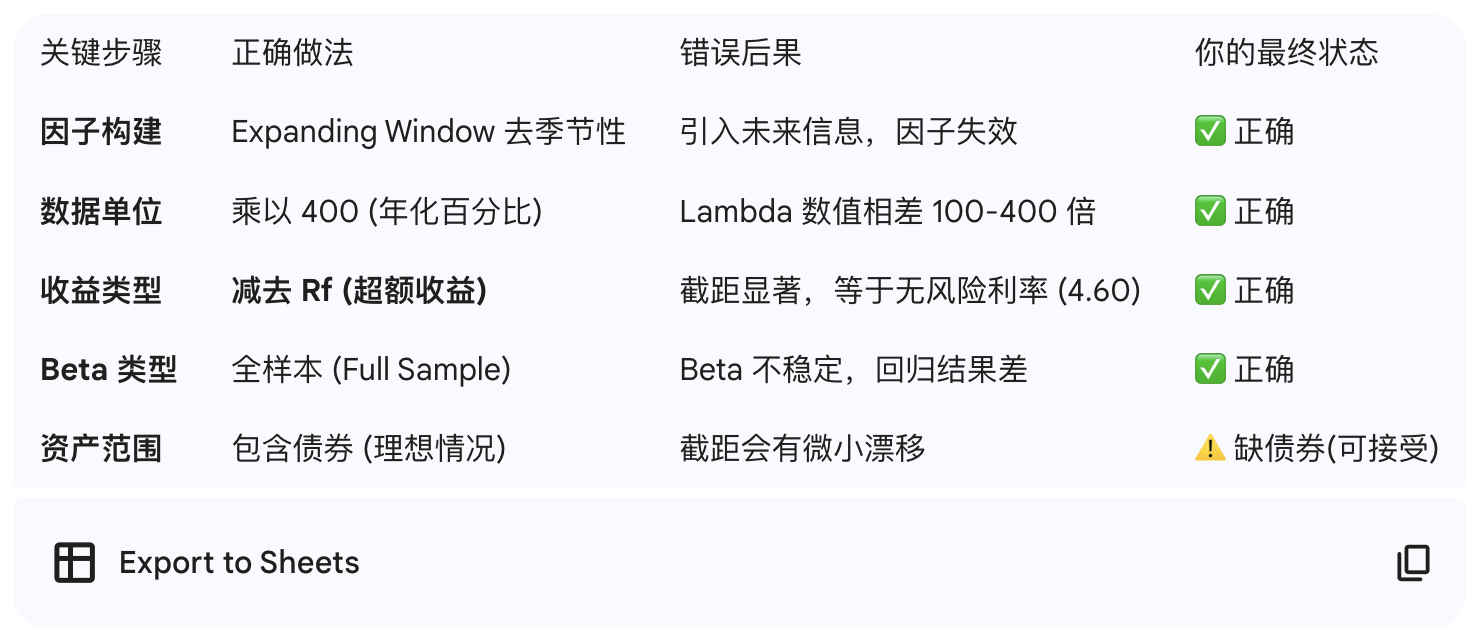

## Figure 4 & 5

Y 轴 (Realized): 测试资产的历史平均超额收益率。$$E[R_i^e] = \frac{1}{T} \sum_{t=1}^T R_{i,t}^e$$X 轴 (Predicted): 模型根据资产风险暴露（Beta）计算出的理论收益率。$$\text{Predicted}_i = \hat{\lambda}_0 + \hat{\beta}_i' \hat{\lambda}$$$\hat{\lambda}_0$: 截距 (Zero-beta rate)，来自横截面回归。$\hat{\beta}_i$: 资产 $i$ 对因子的敏感度，来自时间序列回归。$\hat{\lambda}$: 因子的风险价格 (Risk Price)，来自横截面回归。

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ==========================================
# 1. 定义绘图函数
# ==========================================
def plot_realized_vs_predicted(factors, portfolios, model_name, ax=None):
    """
    factors: 因子数据 (DataFrame), 必须包含截距项(如果有)之外的所有因子
    portfolios: 测试资产数据 (DataFrame)
    model_name: 图表标题
    """
    # --- Step 1: 获取 Beta (时间序列回归) ---
    X_ts = sm.add_constant(factors)
    betas = []
    for port in portfolios.columns:
        model = sm.OLS(portfolios[port], X_ts).fit()
        betas.append(model.params[factors.columns]) # 只取因子的 Beta
    
    beta_df = pd.DataFrame(betas, index=portfolios.columns)
    
    # --- Step 2: 获取 Lambda 和 预测值 (横截面回归) ---
    avg_returns = portfolios.mean() # Realized Return (Y轴)
    
    #X_xs = sm.add_constant(beta_df) # 加入截距 Lambda_0
    X_xs = beta_df
    model_xs = sm.OLS(avg_returns, X_xs).fit()
    
    predicted_returns = model_xs.predict(X_xs) # Predicted Return (X轴)
    
    # --- Step 3: 绘图 ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
        
    # 绘制散点
    ax.scatter(predicted_returns, avg_returns, alpha=0.6, c='blue', edgecolors='k')
    
    # 绘制 45度线 (完美定价线)
    # 获取坐标轴范围以画线
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    
    # 添加标签 (Labels)
    # 为了防止标签重叠太严重，可以只标记部分，或者使用 adjustText 库(如果已安装)
    for i, txt in enumerate(portfolios.columns):
        ax.annotate(txt, (predicted_returns[i], avg_returns[i]), fontsize=8)

    # 设置轴标签和标题
    ax.set_xlabel('Predicted Expected Return (%)', fontsize=12)
    ax.set_ylabel('Realized Mean Return (%)', fontsize=12)
    ax.set_title(f'Realized vs Predicted Returns: {model_name}', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)


In [ ]:
df_portfolios = merged_data[test_assets_excess.columns] * 400
factors_annual = merged_data[['Mkt-RF', 'SMB', 'HML', 'Mom', 'RF']] * 400 # 因子也统一转一下方便看
df_portfolios.shape,factors_annual.shape

In [ ]:
# ==========================================
# 3. 生成 Figure 4 (FF3 Model)
# ==========================================
fig, ax = plt.subplots(figsize=(8, 6))
plot_realized_vs_predicted(
    factors=factors_annual[['Mkt-RF', 'SMB', 'HML']], 
    portfolios=df_portfolios, 
    model_name="Figure 4: Fama-French 3-Factor",
    ax=ax
)
plt.savefig('Replication_Figure4.png')
plt.show()


In [ ]:
# ==========================================
# 4. 生成 Figure 5 (FF4 / Benchmark)
# ==========================================
# 原文用的是 5因子(含 Bond PC1)，你用 FF3 + Mom 代替
if 'Mom' in factors_annual.columns:
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_realized_vs_predicted(
        factors=factors_annual[['Mkt-RF', 'SMB', 'HML', 'Mom']], 
        portfolios=df_portfolios, 
        model_name="Figure 5: FF3 + Momentum Benchmark",
        ax=ax
    )
    plt.savefig('Replication_Figure5.png')
    plt.show()
else:
    print("缺少 Momentum 因子，无法生成 Figure 5 的替代图。")

## Table VII


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def generate_table_vii(merged_data, size_bm_cols, mom_cols, factor_name='LevFac'):
    """
    生成 Adrian et al. (2014) Table VII 格式的表格
    """
    # 1. 准备数据
    # 因子需要加常数项 (Intercept)
    # 原文 Table VII 说明: "Returns are reported in percent per year" -> * 400
    # "Leverage betas are multiplied by 100" -> * 100
    
    factor = merged_data[factor_name]
    X = sm.add_constant(factor)
    
    # === 部分 A: 25 Size/BM Portfolios (需要重塑为 5x5 矩阵) ===
    # 初始化 4 个 5x5 的容器
    metrics = ['E[R]', 'Beta_Lev', 't-stat', 'R2']
    results_25 = {m: np.zeros((5, 5)) for m in metrics}
    
    # 假设 size_bm_cols 的顺序是标准的: 
    # Small-Lo, Small-2, ..., Small-Hi, ME2-Lo, ..., Big-Hi
    # 行: Size (Small -> Big), 列: BM (Low -> High)
    
    print(f"正在处理 {len(size_bm_cols)} 个 Size/BM 组合...")
    
    for i, port_name in enumerate(size_bm_cols):
        # 确定矩阵坐标 (row, col)
        row = i // 5 # 0-4 (Size)
        col = i % 5  # 0-4 (BM)
        
        # 提取收益率
        y = merged_data[port_name]
        
        # 回归
        model = sm.OLS(y, X).fit()
        
        # 1. Average Return (年化百分比)
        # 注意: 你的数据如果是小数(0.01)，需要*400; 如果已经是百分比，需要*4
        # 这里假设输入是原始小数，所以 * 400
        avg_ret = y.mean() * 400 
        
        # 2. Beta (原文乘了 100)
        beta = model.params[factor_name] * 100
        
        # 3. t-stat
        t_stat = model.tvalues[factor_name]
        
        # 4. R2 (%)
        r2 = model.rsquared * 100
        
        # 填入矩阵
        results_25['E[R]'][row, col] = avg_ret
        results_25['Beta_Lev'][row, col] = beta
        results_25['t-stat'][row, col] = t_stat
        results_25['R2'][row, col] = r2

    # 将 numpy 数组转为 DataFrame 以便美观展示
    rows = ['Small', '2', '3', '4', 'Big']
    cols = ['Low', '2', '3', '4', 'High']
    dfs_25 = {k: pd.DataFrame(v, index=rows, columns=cols) for k, v in results_25.items()}

    # === 部分 B: 10 Momentum Portfolios ===
    print(f"正在处理 {len(mom_cols)} 个 Momentum 组合...")
    mom_results = []
    
    for port_name in mom_cols:
        y = merged_data[port_name]
        model = sm.OLS(y, X).fit()
        
        mom_results.append({
            'Portfolio': port_name,
            'E[R]': y.mean() * 400,
            'Beta_Lev': model.params[factor_name] * 100,
            't-stat': model.tvalues[factor_name],
            'R2 (%)': model.rsquared * 100
        })
    
    df_mom = pd.DataFrame(mom_results).set_index('Portfolio')

    return dfs_25, df_mom


In [ ]:
# 1. 确保你有列名列表 (根据你之前的代码)
# 假设 test_25 和 test_10 是你之前读取的原始 DataFrame
# 或者你可以直接从 merged_data.columns 里切片
cols_size_bm = test_25.columns.tolist() 
cols_mom = test_10.columns.tolist()

# 2. 运行计算
dfs_25, df_mom = generate_table_vii(merged_data, cols_size_bm, cols_mom)

# 3. 打印类似原文的效果
print("\n" + "="*60)
print("TABLE VII REPLICATION: Time-Series Regressions")
print("="*60)
print("\n--- Panel A: Size and Book-to-Market Portfolios ---")

print("\n1. E[R]: Average (Annualized) Returns (%)")
print(dfs_25['E[R]'].round(4))

print("\n2. Beta_Lev: Leverage Betas (x 100)")
print(dfs_25['Beta_Lev'].round(4))

print("\n3. t-stats")
print(dfs_25['t-stat'].round(4))

print("\n4. R-square (%)")
print(dfs_25['R2'].round(4))

print("\n" + "-"*60)
print("\n--- Panel B: Momentum Portfolios ---")
print(df_mom.round(4))
print("\n" + "="*60)

## Leverage Mimicking Portfolio（LMP）

### 6 portfolios

In [ ]:
benchmark_6 = pd.read_csv('datasets/6_Portfolios_2x3.csv', skiprows=15, index_col=0)
benchmark_6.index = pd.to_datetime(benchmark_6.index, format='%Y%m')
benchmark_6 = benchmark_6 / 100.0
benchmark_6_quarterly = benchmark_6.resample('Q-JAN').apply(compound_returns)
benchmark_6_quarterly.index = benchmark_6_quarterly.index.to_period('Q')
#benchmark_6_quarterly = benchmark_6_quarterly.subtract(ff_factors_quarterly['RF'], axis=0)
benchmark_6_quarterly.head()

In [ ]:
merged_data = pd.concat([ff_factors_quarterly, ff_Mom_quarterly, benchmark_6_quarterly], axis=1).sort_index().dropna()
merged_data.to_csv('merged_data.csv')
merged_data.head(3)

In [ ]:
merged_data = pd.concat([test_assets_excess, ff_factors_quarterly, fred_data[['LevFac']], ff_Mom_quarterly, benchmark_6_quarterly], axis=1).sort_index()
#merged_data.to_csv('merged_data.csv')
merged_data = merged_data.loc["1936Q1":"2009Q4"]
merged_data.head(3)

### LMP

根据 Adrian et al. (2014) 的方法，构建 FMP 非常简单，本质上就是一个线性回归：$$LevFac_t = \alpha + \beta' \mathbf{R}_t + \epsilon_t$$
- 因变量 ($Y$): 宏观因子 LevFac。
- 自变量 ($X$): BL, BM, BH, SL, SM, SH, Mom
- LMP 收益率: 回归的拟合值 (Fitted Values)，即 $\hat{LevFac}_t = \hat{\alpha} + \hat{\beta}' \mathbf{R}_t$。

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def construct_fmp(merged_data, benchmark_name, factor_name='LevFac'):
    """
    构建因子模仿组合 (Factor Mimicking Portfolio)
    """
    # 1. 准备数据
    # Y: 宏观因子 (LevFac)
    Y = merged_data[factor_name]
    
    # X: benchmark_name
    # 必须包含截距项
    X = merged_data[benchmark_name]
    X = sm.add_constant(X)
    
    # 2. 跑回归
    model = sm.OLS(Y, X).fit()
    
    # 3. 获取拟合值 (这就是 FMP 的收益率)
    # FMP return = Predicted values from the regression
    beta = model.params[1:]/model.params[1:].sum()
    fmp_returns = (beta * merged_data[benchmark_name]).sum(axis=1)
    print(beta)
    print(merged_data[benchmark_name])
    fmp_returns.name = 'LevFac_FMP'
    
    # 打印统计量看看
    print(f"FMP Construction R-squared: {model.rsquared:.4f}")
    #print(f"Correlation with original factor: {Y.corr(fmp_returns):.4f}")
    
    return fmp_returns,beta


In [ ]:
benchmark_name = ['SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'BIG LoBM', 'ME2 BM2',
       'BIG HiBM', 'Mom']   # 7 benchmark

# 计算 FMP 收益率
droped_merged_data = merged_data.dropna()
LevFac_LMP,beta = construct_fmp(droped_merged_data, benchmark_name, factor_name='LevFac')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def plot_figure_6(merged_data, LevFac_LMP, scale):
    """
    复现 Figure 6 (scale：'month' or 'quarter'):
    将季度数据转换为月度等效统计量，以匹配原文 0-5 的视觉范围。
    """
    # 1. 定义资产
    six_portfolios = ['SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'BIG LoBM', 'ME2 BM2', 'BIG HiBM']
    four_factors = ['Mkt-RF', 'SMB', 'HML', 'Mom']
    
    # 2. 数据准备
    #df_frontier = merged_data[four_factors].dropna()
    df_frontier = merged_data[six_portfolios + four_factors].dropna()
    df_p = merged_data[six_portfolios + four_factors].dropna()
    #df_frontier = merged_data[six_portfolios].dropna()
    #df_p = merged_data[six_portfolios].dropna()
    print("frontier:", df_frontier.index)
    print("frontier:", df_frontier.columns)
    print("P:", df_p.index)
    print("P:", df_p.columns)
    
    
    # 强制转小数
    if df_frontier.abs().mean().mean() > 0.1: df_frontier /= 100.0
    if df_p.abs().mean().mean() > 0.1: df_p /= 100.0
    
    # LMP
    s_lmp = LevFac_LMP.dropna()
    if s_lmp.abs().mean() > 0.1: s_lmp /= 100.0
    print('LMP:', s_lmp.index)
    # === 3. 关键转换：季度 -> 月度 ===
    # 假设数据是季度频率 (Quarterly)
    # 月度均值 = 季度均值 / 3
    # 月度波动 = 季度波动 / sqrt(3)
    if scale == 'quarter_to_month':
        scale_val = 3
        SQRT_scale = np.sqrt(3)
    elif scale == 'month':
        scale_val = 1
        SQRT_scale = 1
        
    mu_f = df_frontier.mean() / scale_val
    cov_f = df_frontier.cov() / scale_val
    
    mu_p_vec = df_p.mean() / scale_val
    cov_p_mat = df_p.cov() / scale_val
    
    # === 4. 计算 P 点 (4因子) ===
    inv_cov_p = np.linalg.inv(cov_p_mat)
    w_p = inv_cov_p @ mu_p_vec
    w_p /= w_p.sum()
    
    mu_p_val = w_p @ mu_p_vec
    std_p_val = np.sqrt(w_p @ cov_p_mat @ w_p)
    
    # === 5. 计算有效前沿 (10资产) ===
    def get_var(w): return w @ cov_f @ w
    
    # GMVP
    n_assets = len(df_frontier.columns)
    res_gmvp = minimize(get_var, np.ones(n_assets)/n_assets, 
                       constraints=({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}), 
                       method='SLSQP', tol=1e-12)
    mu_gmvp = res_gmvp.x @ mu_f
    w_gmvp = res_gmvp.x

    # Upper Frontier
    def solve_for_return(target_r, start_w):
        cons = ({'type': 'eq', 'fun': lambda w: w @ mu_f - target_r},
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        return minimize(get_var, start_w, constraints=cons, method='SLSQP', tol=1e-12)

    upper_returns = np.linspace(mu_gmvp, max(mu_p_val, 0.01) * 1.5, 50)
    upper_stds = []
    curr_w = w_gmvp
    
    for r in upper_returns:
        res = solve_for_return(r, curr_w)
        if res.success:
            upper_stds.append(np.sqrt(res.fun))
            curr_w = res.x
        else:
            upper_stds.append(np.nan)

    # Lower Frontier (新增：下半部分)
    # 向下计算到 -0.2% (即 -0.002)
    lower_returns = np.linspace(mu_gmvp, -0.002, 30)
    lower_stds = []
    curr_w = w_gmvp # 重置热启动

    for r in lower_returns:
        res = solve_for_return(r, curr_w)
        if res.success:
            lower_stds.append(np.sqrt(res.fun))
            curr_w = res.x
        else:
            lower_stds.append(np.nan)
            
            
    # === 6. 绘图 (Monthly Scale) ===
    plt.figure(figsize=(8, 6))
    size = 40
    # 绘图时乘 100 转为百分比
    plt.plot(np.array(upper_stds)*100, upper_returns*100, 'b-', linewidth=1)
    plt.plot(np.array(lower_stds)*100, lower_returns*100, 'b-', linewidth=1)
    
    plt.scatter([std_p_val*100], [mu_p_val*100], color='blue', marker='o', s=size, zorder=10)
    plt.text(std_p_val*100 + 0.1, mu_p_val*100, 'P', fontsize=12, color='blue')
    plt.plot([0, std_p_val*100], [0, mu_p_val*100], 'b-', linewidth=1)
    print(std_p_val, mu_p_val)
    
    if s_lmp is not None:
        mu_lmp = (s_lmp.mean() / scale_val) * 100
        std_lmp = (s_lmp.std() / SQRT_scale) * 100
        plt.scatter([std_lmp], [mu_lmp], color='red', marker='o', s=size, zorder=10)
        plt.text(std_lmp + 0.1, mu_lmp - 0.1, 'LMP', fontsize=12, color='red')
        plt.plot([0, std_lmp], [0, mu_lmp], 'b-', linewidth=1)

    # 背景资产
    for asset in df_frontier.columns:
        ser = df_frontier[asset]
        # 转为月度统计量
        a_mu = (ser.mean() / scale_val) * 100
        a_std = (ser.std() / SQRT_scale) * 100
        
        is_factor = asset in four_factors
        color = 'black' if is_factor else 'white'
        plt.scatter([a_std], [a_mu], color=color, s=size, alpha=0.7)
        if is_factor:
            plt.text(a_std + 0.1, a_mu, asset, fontsize=12, color='black')
            plt.plot([0, a_std], [0, a_mu], 'b-', linewidth=1)

    plt.xlabel('Sigma (Monthly %)', fontsize=12)
    plt.ylabel('E(R) (Monthly %)', fontsize=12)
    plt.title('Figure 6 Replication (Monthly Scale)', fontsize=14)
    #plt.axhline(0, color='black', linewidth=1)
    
    plt.xlim(0, 5.5)  # 强制 0-5 范围
    #plt.xlim(0, 10)
    plt.ylim(-0.2, 1.2)
    #plt.grid(True, linestyle=':', alpha=0.3)
    #plt.legend()
    #plt.tight_layout()
    plt.show()


### 季度数据

In [ ]:
plot_figure_6(merged_data, LevFac_LMP, scale='quarter_to_month')

### 月度数据

In [ ]:

ff_factors = pd.read_csv('datasets/F-F_Research_Data_Factors.csv', skiprows=4, index_col=0)
#ff_factors.index = pd.to_datetime(ff_factors.index, format='%Y%m')
ff_factors = ff_factors/100.0

ff_Mom = pd.read_csv('datasets/F-F_Momentum_Factor.csv', index_col=0)
#ff_Mom.index = pd.to_datetime(ff_Mom.index, format='%Y%m')
ff_Mom = ff_Mom/100.0

benchmark_6 = pd.read_csv('datasets/6_Portfolios_2x3.csv', skiprows=15, index_col=0)
#benchmark_6.index = pd.to_datetime(benchmark_6.index, format='%Y%m')
benchmark_6 = benchmark_6 / 100.0
#benchmark_6_quarterly = benchmark_6_quarterly.subtract(ff_factors_quarterly['RF'], axis=0)

merged_data = pd.concat([ff_factors, ff_Mom, benchmark_6], axis=1).sort_index().dropna()
merged_data = merged_data.loc["193601":"200912"]
merged_data.tail()

In [ ]:
plot_figure_6(merged_data, LevFac_LMP, scale='month')